In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import missingno as msno
from sklearn.preprocessing import LabelEncoder

In [2]:
# Import and read data as pandas dataframe.
# The data is already divided into a training and test set. The other participants in the competition used this distribution.
# In orde to compare our resolt we keep the same test and training set.
gender_survived = pd.read_csv("gender_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

First step is to look at the data to see which columns contain valuable information and which can be removed. Furthermore, I will look at the different categories to see if there are missing or strange values.

In [3]:
test.insert(1,'Survived',gender_survived['Survived'])

In [4]:
# merge all data, but keep track of where the test and training set are
data = train.append(test, sort=False)
data = data.reset_index(drop=True)

In [5]:
#Look at each column and their setlist. 

# PASSENGERID
# The Passengger ID has nothing to do with the individual and is added for computational reasons.
# For this reason the column 'PassengerId' is not used in the prediction models.
data = data.drop(columns=['PassengerId'])

# SURVIVED
# No strange values.
print('setlist Survived',list(set(data['Survived'])))

# PCLASS
# No strange values.
print('setlist Pclass',list(set(data['Pclass'])))

# NAME
# Extract a column with each persons title and extract a column for cousins by using the last names and ticket number.
# Finally, remove this column


# SEX
# No strange values.
# Not all ML algorithms like categorical descriptions, so translate these values to numerical represnetations.
print('setlist sex',list(set(data['Sex'])))
# Make categories numerical
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
print()

# AGE
counter = data.Age.isnull().values.sum()
print('There are',counter, 'people in the dataset of whom the age is not known.')
print('Possible solution: replace nan with average age, guess age based on other data, remove rows, or guess from distribution.')
print()

# SIBSP
# No strange values.
print('setlist SibSp', list(set(data['SibSp'])))

# PARCH
# No strange values.
print('setlist Parch',list(set(data['Parch'])))
print()

# TICKET
# No nan values
print('Number of different Ticket types',len(list(set(data['Ticket']))))
print()

# FARE
Fare = data['Fare']
counter = 0
for i in Fare:
    if i == 0 or i < 0:
        counter+=1
print('There are',counter,'people in the dataset who did not pay for their ticket.')
print('This could be outliers.')
counter = data.Fare.isnull().values.sum()
print('There are',counter, 'people in the dataset whos fare is nan.')
# Give missing fare values the mean fare value.
data.Fare.fillna(np.mean(data['Fare']), inplace = True)
print()

# CABIN
print('Number of different Cabin categories',len(list(set(data['Cabin']))))
nan_cabins = data.Cabin.isnull().values.sum()
print('The number of people whos cabin number is nan is', nan_cabins)
# Give all nan cabins the same name
data.Cabin = data.Cabin.fillna('NO_CABIN')
print()

# EMBARKED
print('setlist Embarked',list(set(data['Embarked'])))
counter = data.Embarked.isnull().values.sum()
print('There are',counter, 'people in the dataset who embarked from nan.')
print('Possible solution: make a guess, or remove rows.')
# There are two people from whom we do not knwo where they embarked
# We give these people the most frequently occuring value in the dataset.
data.Embarked.fillna(data.Embarked.mode()[0], inplace = True)
# Make numerical
data['Embarked'] = LabelEncoder().fit_transform(data['Embarked'])

setlist Survived [0, 1]
setlist Pclass [1, 2, 3]
setlist sex ['male', 'female']

There are 263 people in the dataset of whom the age is not known.
Possible solution: replace nan with average age, guess age based on other data, remove rows, or guess from distribution.

setlist SibSp [0, 1, 2, 3, 4, 5, 8]
setlist Parch [0, 1, 2, 3, 4, 5, 6, 9]

Number of different Ticket types 929

There are 17 people in the dataset who did not pay for their ticket.
This could be outliers.
There are 1 people in the dataset whos fare is nan.

Number of different Cabin categories 187
The number of people whos cabin number is nan is 1014

setlist Embarked [nan, 'Q', 'C', 'S']
There are 2 people in the dataset who embarked from nan.
Possible solution: make a guess, or remove rows.


<AxesSubplot:>

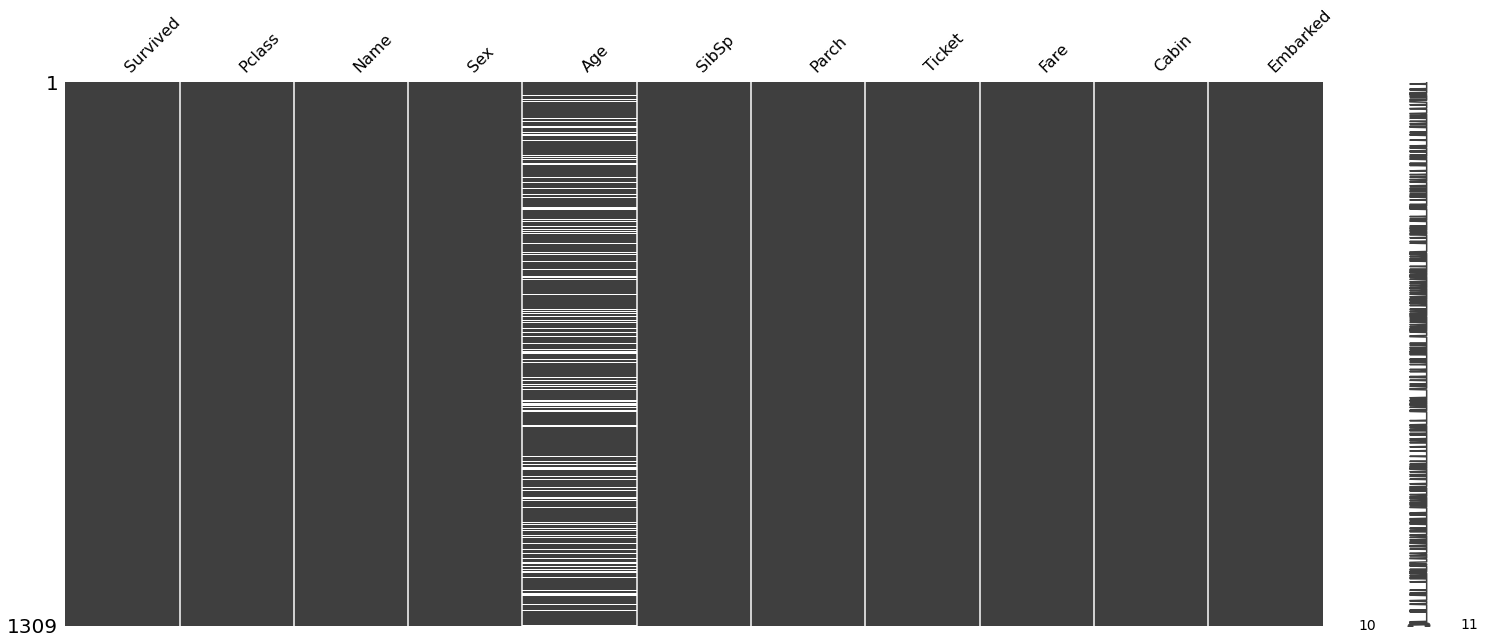

In [6]:
msno.matrix(data)
# Only missing values are age values

In [7]:
# Make column with only last_names
names = data['Name'].copy(deep = True)
for row in range(len(data)):
    name = names[row]
    splitted = name.split()
    last_name = splitted[0]
    last_name = last_name[:-1]
    names.loc[row] = last_name.lower()
data['Last_names'] = names
data['Last_names'] = LabelEncoder().fit_transform(data['Last_names'])

In [8]:
data['Title'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip().lower()) 
data['Title'] = LabelEncoder().fit_transform(data['Title'])

In [9]:
# Make a columns with only the ticket numbers.
cleaned_tickets = data['Ticket'].copy(deep = True)
for row in range(len(data)):
    ticket = cleaned_tickets[row]
    if isinstance(ticket, int):
        continue
    if ticket.isdigit():
        cleaned_tickets[row] = int(ticket)
    else:
        splitted = ticket.split()
        if splitted[-1].isdigit(): 
            cleaned_tickets.loc[row] = int(splitted[-1])

# Collect the indices of rows which are not integers.
to_be_removed_rows = []
for i in range(len(cleaned_tickets)):
    if not isinstance(cleaned_tickets[i], int):
        to_be_removed_rows.append(i)
        
data['Tickets_nr'] = cleaned_tickets

In [10]:
# Extract the train and test set, and remove the rows where the ticket nr is not an integer
train = data.iloc[0:len(train)]
test = data.iloc[len(train):]

train = train.drop(train.index[to_be_removed_rows])
train = train.reset_index(drop=True)

In [11]:
# merge all data again, but keep track of where the test and training set are
data = train.append(test, sort=False)
data = data.reset_index(drop=True)

In [12]:
# We can use the last name and ticket number column to find family members which are not directly related.
# People with the same or consecutive ticket numbers and same last name are likely family.

# make a dataframe and set all values to 0
cousins = data['Sex'].copy(deep = True)
for i in range(len(cousins)):
    cousins.loc[i] = 0

# If another person has the same lastname and a neghbouring ticket (within a range of 10), then they are considered family
ticks = data['Tickets_nr']
names = data['Last_names']
for person_id in range(len(cousins)):
    family_members = 0
    ticket = data['Tickets_nr'][person_id]
    last_name = data['Last_names'][person_id]
    for passenger_id in range(len(cousins)):
#         if you find the person itself, continue
        if passenger_id == person_id:
            continue
        if last_name == names[passenger_id] and ticket-10 <= ticks[person_id] <= ticket+10:
            family_members+=1
    cousins.loc[person_id] = family_members
    
#  Add column to dataframe
data['Cousins'] = cousins

In [13]:
# All useable data is removed from data column, remove column
data = data.drop(columns=['Name'])

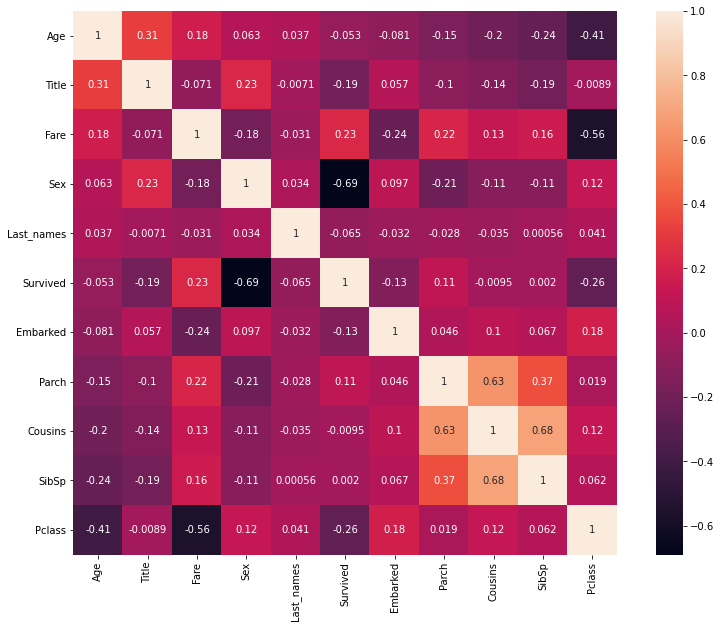

In [14]:
# Produce correlation heatmap, to see which columns correlate with the age.
def make_corrmap(data, vactor):
    corrmat = data.corr()
    k = 20 #Number of variables for heat map with largest correlation.
    cols = corrmat.nlargest(k, vactor)[vactor].index
    f, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(data[cols].corr(), vmax=1, square=True, annot=True);

make_corrmap(data, 'Age')

# Conclusion all available variables have correlation, but categorica variables are not suitable for this heatmap.
# The variable Title, Sex, Last_names, Survived, Embarked,and Pclass are actually not suitable for multivariate regression beacuse they are categorical.

In [15]:
# Make a age testing dataset with only the passengers of whom the age is known.
pred_age = data.copy(deep=True)
index_ageless = []
# Get all indices of agless people.
for row in range(len(pred_age)):
    if math.isnan(pred_age['Age'][row]):
        index_ageless.append(row)
pred_age = pred_age.drop(pred_age.index[index_ageless])
pred_age = pred_age.reset_index(drop=True)

In [23]:
# Inititally only the numerical columsn were used, but after some testing the accuracy went up if the columsn 'Sex' and 'Title' were also used
# Make a linear regression model for the prediction of age.
reg = linear_model.LinearRegression()
reg.fit(pred_age[['Title','Sex','Fare','Parch', 'Cousins','SibSp']],pred_age['Age'])

LinearRegression()

In [24]:
# Test performance of age predictor.
correct = 0
sum_square_error_pred = 0
for i in range(len(pred_age)):
    true_age = pred_age['Age'][i]
    Title = data['Title'][i]
    Fare = data['Fare'][i]
    Sex = data['Sex'][i]
    Parch = data['Parch'][i]
    Cousins = data['Cousins'][i]
    SibSp = data['SibSp'][i]
    pred = np.round(reg.predict([[Title,Sex, Fare, Parch, Cousins, SibSp]]))
    sum_square_error_pred += (pred - true_age )**2
#     Correct if age is guessed within 3 years
    if true_age - 3 <= pred <= true_age + 3:
        correct+=1
print("The mean squared error of the age predictor is", np.mean(sum_square_error_pred))
print('The age predictor is correct in', (correct/len(pred_age))*100, '% of the cases')

# Test performance of random distributed guesser

def age_guesser():
    correct = 0
    sum_square_error_pred = 0
    for i in range(len(pred_age)):
        true_age = pred_age['Age'][i]
        row = random.randint(0, len(pred_age)-1)
        guess = pred_age['Age'][row]
        sum_square_error_pred += (guess - true_age )**2
        if true_age-3 <= guess <= true_age+3:
            correct+=1
    return(correct, np.mean(sum_square_error_pred))

correct_guesses = []
square_errors = []
for i in range(1000):
    cor, err = age_guesser()
    correct_guesses.append(cor)
    square_errors.append(err)

average_correct = np.mean(correct_guesses)
    
    
print("The mean squared error of the random guesser isis", np.mean(square_errors))
print('the random age guesser is correct in', (average_correct/len(pred_age))*100, '% of the cases')

The mean squared error of the age predictor is 249686.76009999998
The age predictor is correct in 19.001919385796544 % of the cases
The mean squared error of the random guesser isis 432661.27855789993
the random age guesser is correct in 15.01324376199616 % of the cases


In [18]:
# The age prediction model has a better performance and a lower mean squared error.
# Meaning that it is better at predicting a passengers age, use this technnique to fill in missing values.
index_ageless = []
for row in range(len(data)):
    if math.isnan(data['Age'][row]):
        index_ageless.append(row)

for i in index_ageless:
    Title = data['Title'][i]
    Fare = data['Fare'][i]
    Sex = data['Sex'][i]
    Parch = data['Parch'][i]
    Cousins = data['Cousins'][i]
    SibSp = data['SibSp'][i]
    pred = np.round(reg.predict([[Title, Sex, Fare, Parch, Cousins, SibSp]]))
    data.loc[i, 'Age'] = pred
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_names,Title,Tickets_nr,Cousins
0,0,3,1,22.0,1,0,A/5 21171,7.2500,NO_CABIN,2,100,12,21171,1
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,0,182,13,17599,1
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NO_CABIN,2,331,9,3101282,0
3,1,1,0,35.0,1,0,113803,53.1000,C123,2,269,13,113803,1
4,0,3,1,35.0,0,0,373450,8.0500,NO_CABIN,2,15,12,373450,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,0,3,1,32.0,0,0,A.5. 3236,8.0500,NO_CABIN,2,755,12,3236,0
1301,1,1,0,39.0,0,0,PC 17758,108.9000,C105,0,595,3,17758,0
1302,0,3,1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NO_CABIN,2,701,12,3101262,0
1303,0,3,1,32.0,0,0,359309,8.0500,NO_CABIN,2,825,12,359309,3


<AxesSubplot:>

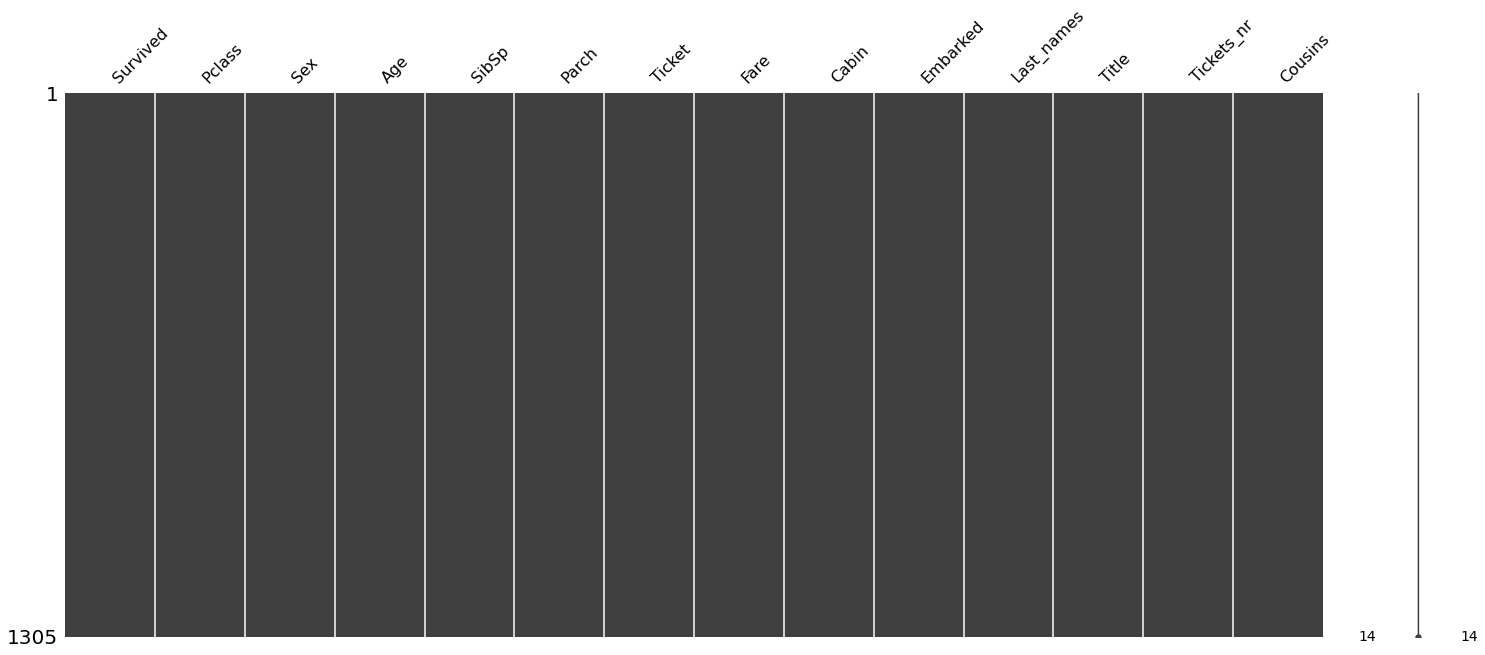

In [19]:
msno.matrix(data)

# Data visualisation


In [20]:
# # Extract the train and test set
# train = data.iloc[0:len(train)]
# test = data.iloc[len(train):]

In [25]:
data.nunique()

Survived        2
Pclass          3
Sex             2
Age            99
SibSp           7
Parch           8
Ticket        928
Fare          282
Cabin         187
Embarked        3
Last_names    864
Title          18
Tickets_nr    923
Cousins         9
dtype: int64

Text(0.5, 1.0, 'Percentage of people survived and Deceased')

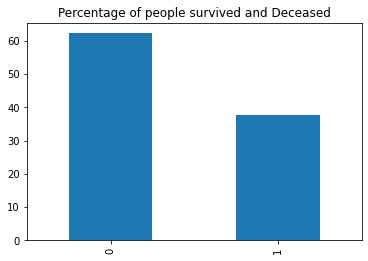

In [48]:
(data.Survived.value_counts(normalize=True) * 100).plot.bar().set_title("Percentage of people survived and Deceased")
# About 60% of the people in the dataset died

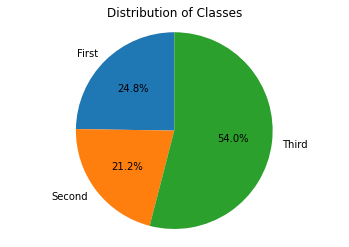

In [84]:
# Most people are third class passengers and about a quarter of the passengers are first class 
classes = data.Pclass.value_counts().tolist()
first = classes[1]
second = classes[2]
third = classes[0]

labels = 'First', 'Second', 'Third'
sizes = [first, second, third]

fig1, ax1 = plt.subplots()
plt.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
plt.axis('equal') 
plt.title('Distribution of Classes')
plt.show()

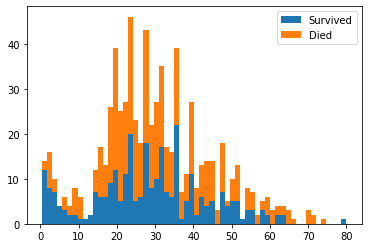

In [88]:
Sur_Age = train.loc[train.Survived == 1]["Age"]
Dead_Age = train.loc[train.Survived == 0]["Age"]

plt.hist([Sur_Age, Dead_Age], bins = 60, histtype = 'barstacked', label = ['Survived', 'Died'])

plt.legend()
plt.show()

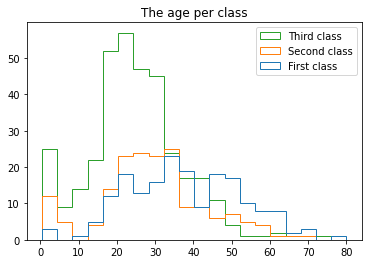

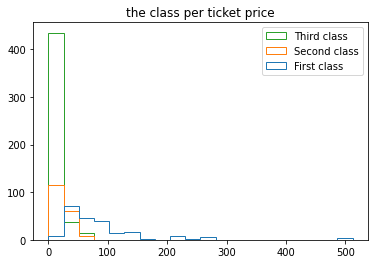

In [101]:
Age_1 = train.loc[data.Pclass ==1]["Age"]
Age_2 = train.loc[data.Pclass ==2]["Age"]
Age_3 = train.loc[data.Pclass ==3]["Age"]

plt.hist([Age_1, Age_2, Age_3], bins = 20, histtype = 'step', label = ['First class', 'Second class', 'Third class'])
plt.legend()
plt.title('The age per class')
plt.show()

Fare_1 = train.loc[data.Pclass ==1]["Fare"]
Fare_2 = train.loc[data.Pclass ==2]["Fare"]
Fare_3 = train.loc[data.Pclass ==3]["Fare"]

plt.hist([Fare_1, Fare_2, Fare_3], bins = 20, histtype = 'step', label = ['First class', 'Second class', 'Third class'])
plt.legend()
plt.title('the class per ticket price')
plt.show()

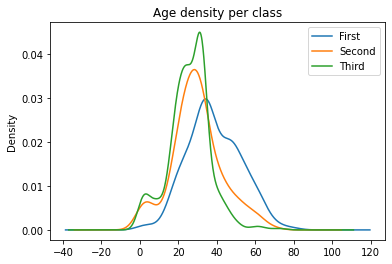

In [99]:
for c in list(set(data['Pclass'])):
    data.Age[data.Pclass == c].plot(kind='kde')
    
plt.title('Age density per class')
plt.legend(('First', 'Second','Third'))
plt.show()

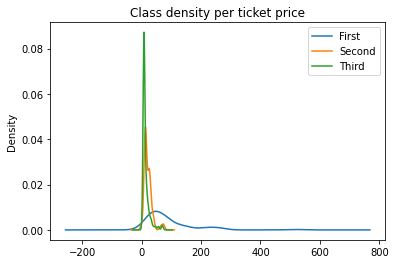

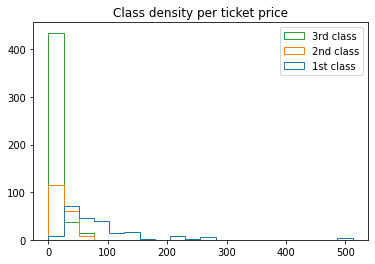

In [103]:
for c in list(set(data['Pclass'])):
    data.Fare[data.Pclass == c].plot(kind='kde')
    
plt.title('Class density per ticket price')
plt.legend(('First', 'Second','Third'))
plt.show()

Fare_1 = train.loc[train.Pclass ==1]["Fare"]
Fare_2 = train.loc[train.Pclass ==2]["Fare"]
Fare_3 = train.loc[train.Pclass ==3]["Fare"]

plt.hist([Fare_1, Fare_2, Fare_3], bins = 20, histtype = 'step', label = ['1st class', '2nd class', '3rd class'])
plt.legend()
plt.title('Class density per ticket price')
plt.show()

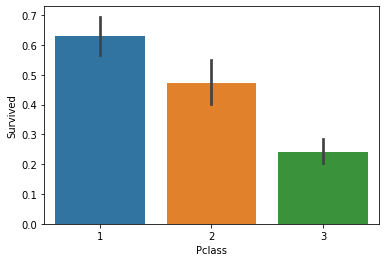

In [87]:
sns.barplot(x='Pclass', y='Survived', data=train);

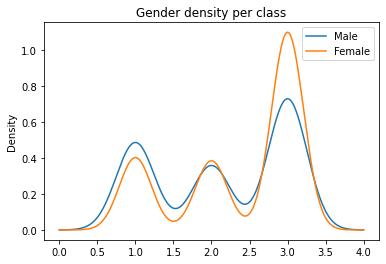

In [105]:
for gender in [0,1]:
    data.Pclass[data.Sex == gender].plot(kind="kde")
plt.title("Gender density per class")
plt.legend(("Male","Female"))

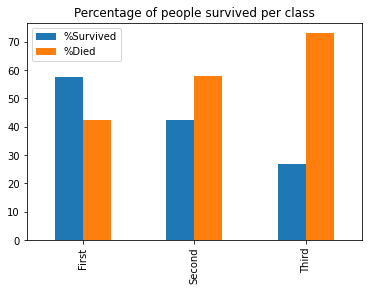

,%Survived,%Died
First,57.585139,42.414861
Second,42.238267,57.761733
Third,26.950355,73.049645


In [116]:
pclass_1_survivor_distribution = (data[data.Pclass == 1].Survived == 1).value_counts()[1]/len(data[data.Pclass == 1]) * 100
pclass_2_survivor_distribution = (data[data.Pclass == 2].Survived == 1).value_counts()[1]/len(data[data.Pclass == 2]) * 100
pclass_3_survivor_distribution = (data[data.Pclass == 3].Survived == 1).value_counts()[1]/len(data[data.Pclass == 3]) * 100

pclass_perc_df = pd.DataFrame(
    { "%Survived":{"First": pclass_1_survivor_distribution,"Second": pclass_2_survivor_distribution, "Third": pclass_3_survivor_distribution},  
     "%Died":{"First": 100-pclass_1_survivor_distribution,"Second": 100-pclass_2_survivor_distribution, "Third": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Percentage of people survived per class")
plt.show()

pclass_perc_df

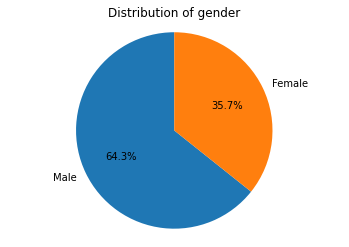

In [137]:
# Most people are third class passengers and about a quarter of the passengers are first class 
gender =  data.Sex.value_counts().tolist()
male = gender[0]
female = gender[1]

labels = 'Male', 'Female'
sizes = [male, female]

fig1, ax1 = plt.subplots()
plt.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
plt.axis('equal') 
plt.title('Distribution of gender')
plt.show()

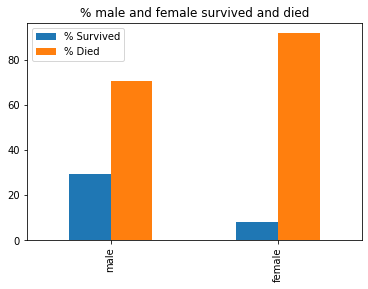

In [134]:
male_pr = (data[data.Sex == 0].Survived == 1).value_counts()[1]/len(data.Sex) * 100
female_pr = (data[data.Sex == 1].Survived == 1).value_counts()[1]/len(data.Sex) * 100

sex_perc_df = pd.DataFrame(
    { "% Survived":{"male": male_pr,"female": female_pr},  "% Died":{"male": 100-male_pr,"female": 100-female_pr}})
sex_perc_df.plot.bar().set_title("% of male and female survived and died")
plt.show()

In [138]:
pd.DataFrame(data.Age.describe())

,Age
count,1305.000000
mean,29.795916
std,13.204210
min,0.000000
25%,22.000000
50%,30.000000
75%,36.000000
max,80.000000


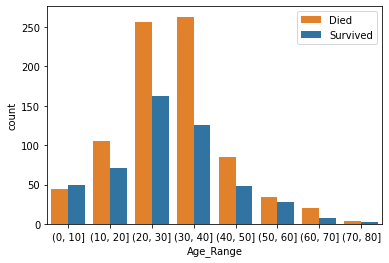

In [141]:
data['Age_Range'] = pd.cut(data.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
sns.countplot(x = "Age_Range", hue = "Survived", data = data, palette=["C1", "C0"]).legend(labels = ["Died", "Survived"])
plt.show()

In [142]:
data.SibSp.describe()

count    1305.000000
mean        0.500383
std         1.042888
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Text(0.5, 1.0, 'Training Data - Number of siblings or spouses vs survival count')

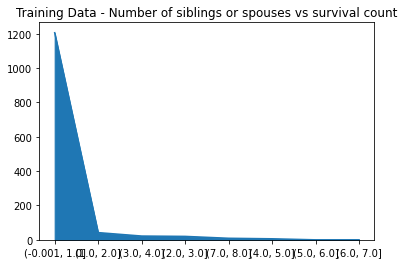

In [143]:
ss = pd.DataFrame()
ss['survived'] = data.Survived
ss['sibling_spouse'] = pd.cut(data.SibSp, [0, 1, 2, 3, 4, 5, 6,7,8], include_lowest = True)
(ss.sibling_spouse.value_counts()).plot.area().set_title("Training Data - Number of siblings or spouses vs survival count")

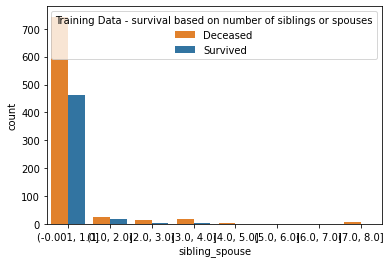

In [144]:
x = sns.countplot(x = "sibling_spouse", hue = "survived", data = ss, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data - survival based on number of siblings or spouses")

In [146]:
pd.DataFrame(data.Parch.describe())

,Parch
count,1305.000000
mean,0.386207
std,0.866624
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


Text(0.5, 1.0, 'Training Data - Number of parents/children and survival density')

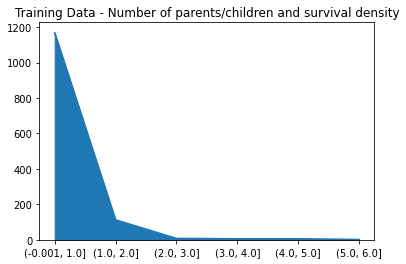

In [147]:
pc = pd.DataFrame()
pc['survived'] = data.Survived
pc['parents_children'] = pd.cut(data.Parch, [0, 1, 2, 3, 4, 5, 6], include_lowest = True)
(pc.parents_children.value_counts()).plot.area().set_title("Training Data - Number of parents/children and survival density")

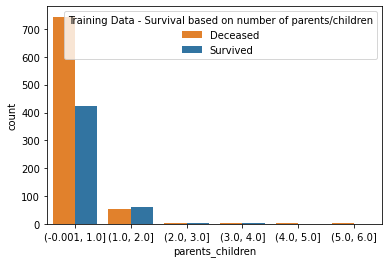

In [148]:
x = sns.countplot(x = "parents_children", hue = "survived", data = pc, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data - Survival based on number of parents/children")


In [150]:
data.Fare.describe()

count    1305.000000
mean       33.397534
std        51.785249
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [152]:
data['Fare_Category'] = pd.cut(data['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid',
                                                                                      'High_Mid','High'])

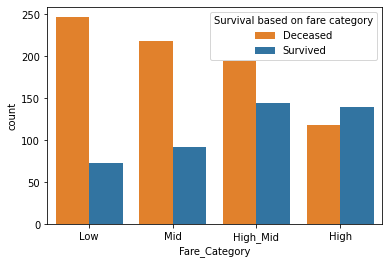

In [154]:
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = data, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Survival based on fare category")

Text(0.5, 1.0, 'Training Data - Survival based on embarking point.')

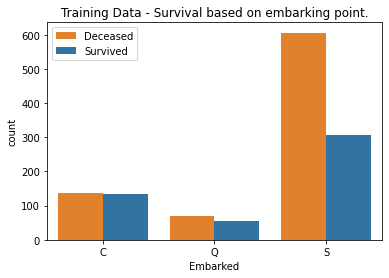

In [158]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = data, palette=["C1", "C0"])
p.set_xticklabels(["C","Q","S"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("Training Data - Survival based on embarking point.")

In [156]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_names,Title,Tickets_nr,Cousins,Age_Range,Fare_Category
0,0,3,1,22.0,1,0,A/5 21171,7.2500,NO_CABIN,2,100,12,21171,1,"(20, 30]",Low
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,0,182,13,17599,1,"(30, 40]",High
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NO_CABIN,2,331,9,3101282,0,"(20, 30]",Mid
3,1,1,0,35.0,1,0,113803,53.1000,C123,2,269,13,113803,1,"(30, 40]",High
4,0,3,1,35.0,0,0,373450,8.0500,NO_CABIN,2,15,12,373450,1,"(30, 40]",Mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,0,3,1,32.0,0,0,A.5. 3236,8.0500,NO_CABIN,2,755,12,3236,0,"(30, 40]",Mid
1301,1,1,0,39.0,0,0,PC 17758,108.9000,C105,0,595,3,17758,0,"(30, 40]",High
1302,0,3,1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NO_CABIN,2,701,12,3101262,0,"(30, 40]",Low
1303,0,3,1,32.0,0,0,359309,8.0500,NO_CABIN,2,825,12,359309,3,"(30, 40]",Mid
